## Imports

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import fbeta_score, roc_auc_score

from skopt import BayesSearchCV

import shap

import warnings
warnings.filterwarnings("ignore")

## Read Dataset

In [28]:
data = pd.read_csv("data/Heart_Disease_Kaggle_Preprocessed.csv")
print(data.shape)
data.head()

(268, 14)


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,ECG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,1.733026,0.681528,0.871534,-0.064103,1.407389,-0.418854,0.977857,-1.777056,-0.699206,1.193857,0.680101,2.462874,-0.881493,1
1,1.400801,-1.467290,-0.180588,-0.914581,6.109512,-0.418854,0.977857,0.437459,-0.699206,0.491048,0.680101,-0.715538,1.181740,0
2,0.293383,0.681528,-1.232710,-0.404294,0.222143,-0.418854,-1.022644,-0.387556,-0.699206,-0.651016,-0.947283,-0.715538,1.181740,1
3,1.068576,0.681528,0.871534,-0.177500,0.261004,-0.418854,-1.022644,-1.950743,1.430194,-0.738867,0.680101,0.343933,1.181740,0
4,2.175994,-1.467290,-1.232710,-0.631088,0.377585,-0.418854,0.977857,-1.255994,1.430194,-0.738867,-0.947283,0.343933,-0.881493,0


## Data split

In [29]:
X = data.drop(columns=["Heart Disease"])
y = data["Heart Disease"]

## Cross-validation with Bayesian Optimization

In [30]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search_space = {
    'n_estimators': (10, 500),  # Number of trees
    'max_depth': (1, 50),  # Maximum depth of each tree
    'learning_rate': (0.001, 0.1, 'uniform'),  # Learning rate
    'subsample': (0.5, 1.0),  # Subsample ratio of the training data
    'colsample_bytree': (0.5, 1.0),  # Subsample ratio of features
    'gamma': (0, 5),  # Regularization parameter
    'min_child_weight': (1, 20)  # Minimum sum of instance weight (hessian) needed in a child
}

opt_xgb = BayesSearchCV(
    XGBClassifier(random_state=42),
    search_spaces=search_space,
    scoring="roc_auc",
    n_iter=30,
    n_jobs=-1,
    random_state=42
)

In [31]:
fold_results = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    X_train_full, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train_full, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42)
    
    # Fit
    opt_xgb.fit(X_train, y_train)
    
    # Best model
    best_model = opt_xgb.best_estimator_
    y_pred = best_model.predict(X_val)
    y_pred_proba = best_model.predict_proba(X_val)[:, 1]
    
    # Metrics on outer fold
    fold_metrics = {
        "fold": fold + 1,
        "accuracy": accuracy_score(y_val, y_pred),
        "precision": precision_score(y_val, y_pred),
        "recall": recall_score(y_val, y_pred),
        "fbeta_2": fbeta_score(y_val, y_pred, beta=2),
        "roc_auc": roc_auc_score(y_val, y_pred_proba),
        "NNS": 1/precision_score(y_val, y_pred), #np.mean é a prevalencia
        "best_params": opt_xgb.best_params_
    }
    
    fold_results.append(fold_metrics)
    
    print(f"Fold {fold+1}: { {k: round(v, 3) if isinstance(v, float) else v for k, v in fold_metrics.items()} }")

# Compute mean scores
print("\nMean scores across folds:")
for metric in ["accuracy", "precision", "recall", "fbeta_2", "roc_auc", "NNS"]:
    values = [f[metric] for f in fold_results]
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"{metric}: {mean_val:.4f} ± {std_val:.4f}")
    

Fold 1: {'fold': 1, 'accuracy': 0.889, 'precision': 0.909, 'recall': 0.833, 'fbeta_2': 0.847, 'roc_auc': 0.964, 'NNS': 1.1, 'best_params': OrderedDict([('colsample_bytree', 0.7573257910045901), ('gamma', 0), ('learning_rate', 0.02547163598584411), ('max_depth', 22), ('min_child_weight', 2), ('n_estimators', 66), ('subsample', 0.6067449506005353)])}
Fold 2: {'fold': 2, 'accuracy': 0.926, 'precision': 0.885, 'recall': 0.958, 'fbeta_2': 0.943, 'roc_auc': 0.972, 'NNS': 1.13, 'best_params': OrderedDict([('colsample_bytree', 0.7133070793287863), ('gamma', 4), ('learning_rate', 0.09430233277591583), ('max_depth', 46), ('min_child_weight', 3), ('n_estimators', 117), ('subsample', 0.5)])}
Fold 3: {'fold': 3, 'accuracy': 0.778, 'precision': 0.731, 'recall': 0.792, 'fbeta_2': 0.779, 'roc_auc': 0.843, 'NNS': 1.368, 'best_params': OrderedDict([('colsample_bytree', 0.5), ('gamma', 0), ('learning_rate', 0.1), ('max_depth', 1), ('min_child_weight', 7), ('n_estimators', 408), ('subsample', 1.0)])}
Fold

## Feature Importance | SHAP

In [32]:
# Step 1: Find the best fold by ROC AUC
best_fold = max(fold_results, key=lambda x: x["roc_auc"])

# Step 2: Extract best parameters
best_params = best_fold["best_params"]

# Step 3: Create new GaussianNB with best parameters
xgb = XGBClassifier(**best_params)

print(best_params)

OrderedDict([('colsample_bytree', 0.7133070793287863), ('gamma', 4), ('learning_rate', 0.09430233277591583), ('max_depth', 46), ('min_child_weight', 3), ('n_estimators', 117), ('subsample', 0.5)])


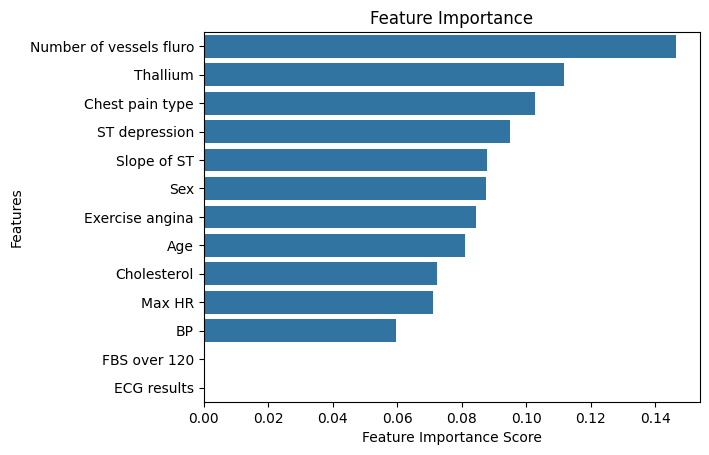

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

# Train xgb model
xgb.fit(X_train, y_train)

feature_importance = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plotting Feature Importance
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

7.1525574e-07


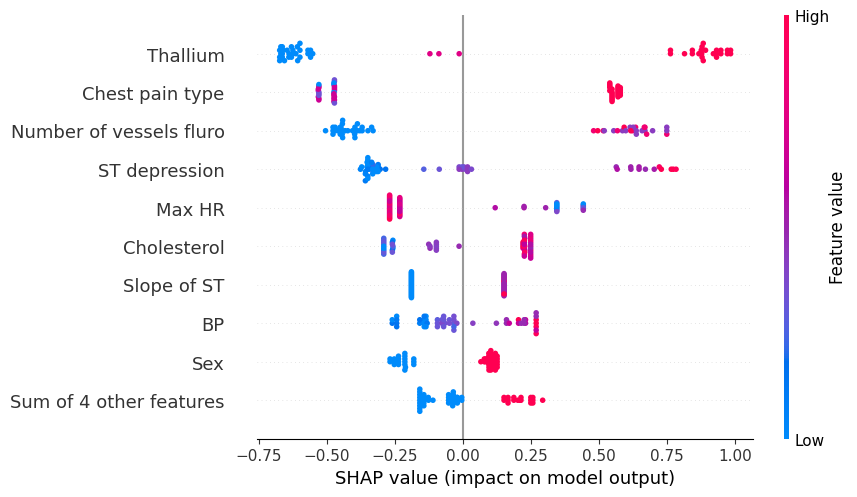

In [34]:
pred = xgb.predict(X_test, output_margin=True)

explainer = shap.TreeExplainer(xgb)
explanation = explainer(X_test)

shap_values = explanation.values

# make sure the SHAP values add up to marginal predictions
print(np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max())

shap.plots.beeswarm(explanation)